In [1]:
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt
import matplotlib
%matplotlib widget
cmap = matplotlib.colormaps.get('tab10').colors
import gen_graph as gg

In [2]:
# LEGACY

# def hexagon_correction(nodes, connections, size):
#     removed_node_indices = []
#     skip_index = -1
#     for i in range(size[0]):
#         # Go through the rows
#         skip_index +=1
#         for j in range(size[1]):
#             # Go through the nodes in the row and remove every third, starting from a different index
#             if (j-skip_index)%3 == 0:
#                 removed_node_indices.append(i*size[1]+j)    
#     nodes = np.delete(nodes, removed_node_indices, axis=0)
#     connections = [edge for edge in connections if edge[0] not in removed_node_indices and edge[1] not in removed_node_indices]
#     connections = np.array(connections)
#     print(removed_node_indices)
#     for i in removed_node_indices:
#         connections[i-1:] -= 1
        
#     return nodes, connections
    

In [3]:
def plot_graph(nodes, connections):
    '''
    Function that plots the graph. It takes the following arguments:
    - nodes (arr): The array of nodes
    - connections (arr): The array of connections
    '''
    _,ax = plt.subplots()
    ax.plot(nodes[:,0], nodes[:,1], 'ro')
    for edge in connections.T:
        ax.plot([nodes[edge[0]][0], nodes[edge[1]][0]], [nodes[edge[0]][1], nodes[edge[1]][1]], 'g-')
    ax.set_aspect('equal')

In [4]:
import torch
import torch_geometric as tg
import random
def load_data(paths):
    dataset = []
    for path in paths:
        graphs = np.load(path)
        dataset.extend([tg.data.Data(
                        x=torch.tensor(graphs['attr'][i], dtype=torch.float),
                        edge_index=torch.tensor(graphs['edges'][i], dtype=torch.int),
                        edge_attr=torch.tensor(graphs['edge_attr'][i], dtype=torch.float),
                        y=torch.tensor(graphs['y'][i], dtype=torch.float),
                        pos=torch.tensor(graphs['coords'][i], dtype=torch.float)  
                         ) for i in range(len(graphs['attr']))])
        print(len(dataset))
        random.shuffle(dataset)
    trainable_graphs = int(0.2 * len(dataset))
    train_loader = tg.loader.DataLoader(dataset[:trainable_graphs], batch_size=5, shuffle=True)
    test_loader = tg.loader.DataLoader(dataset[trainable_graphs:], batch_size=5, shuffle=True)
    return train_loader, test_loader
train_loader, test_loader = load_data(['graphs/hex.npz', 'graphs/rect.npz', 'graphs/sq.npz'])

100
200
300


In [9]:
def plot_graph_tg(data: tg.data.Data):
    '''
    Function that plots the graph. It takes the following arguments:
    - a tg.data.Data object
    '''
    coords = data['pos']
    edges = data['edge_index']
    _,ax = plt.subplots()
    ax.plot(coords[:,0], coords[:,1], 'ro')
    ax.plot((coords[:,0][edges[0]], coords[:,0][edges[1]]), (coords[:,1][edges[0]], coords[:,1][edges[1]]), 'g-')
    
#plot_graph_tg(train_loader.dataset[12])

In [13]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = tg.nn.GCNConv(1, 4)
        self.conv2 = tg.nn.GCNConv(4,8)
        self.classifier = torch.nn.Linear(8, 3)
    def forward(self, x, edge_index, batch):
        x = torch.tanh(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        
        x = tg.nn.global_mean_pool(x, batch)
        out = torch.nn.functional.softmax(self.classifier(x), dim=1)
        
        return out
model = GCN()
print(model)

GCN(
  (conv1): GCNConv(1, 4)
  (conv2): GCNConv(4, 8)
  (classifier): Linear(in_features=8, out_features=3, bias=True)
)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train(loader):
    model.train()
    for data in loader:
        out = model(data.x, data.edge_index, data.batch)# Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        #print(loss)
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad() # Reset grads.
def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        true = data.y.argmax(dim=1)
        #print(true)
        correct += int((true == pred).sum())
    return correct / len(loader.dataset)

In [15]:
for epoch in range(1, 100):
    train(train_loader)
    acc = test(train_loader)
    if epoch % 1 == 0:
        print(f'Epoch: {epoch:03d}, Test Accuracy: {acc:.5f}')

Epoch: 001, Test Accuracy: 0.40000
Epoch: 002, Test Accuracy: 0.40000
Epoch: 003, Test Accuracy: 0.40000
Epoch: 004, Test Accuracy: 0.40000
Epoch: 005, Test Accuracy: 0.40000
Epoch: 006, Test Accuracy: 0.71667
Epoch: 007, Test Accuracy: 0.71667
Epoch: 008, Test Accuracy: 0.71667
Epoch: 009, Test Accuracy: 0.71667
Epoch: 010, Test Accuracy: 0.71667
Epoch: 011, Test Accuracy: 0.71667
Epoch: 012, Test Accuracy: 0.71667
Epoch: 013, Test Accuracy: 0.71667
Epoch: 014, Test Accuracy: 0.71667
Epoch: 015, Test Accuracy: 0.71667
Epoch: 016, Test Accuracy: 0.71667
Epoch: 017, Test Accuracy: 0.71667
Epoch: 018, Test Accuracy: 0.71667
Epoch: 019, Test Accuracy: 0.71667
Epoch: 020, Test Accuracy: 0.71667
Epoch: 021, Test Accuracy: 0.71667
Epoch: 022, Test Accuracy: 0.71667
Epoch: 023, Test Accuracy: 0.71667
Epoch: 024, Test Accuracy: 0.71667
Epoch: 025, Test Accuracy: 0.71667
Epoch: 026, Test Accuracy: 0.71667
Epoch: 027, Test Accuracy: 0.71667
Epoch: 028, Test Accuracy: 0.71667
Epoch: 029, Test Acc

'data_4000.pt'

In [20]:
import numpy as np
rng = np.random.default_rng()

def get_lattice_vectors(scale, binding_angle, initial_length=1):
    '''
    Function that returns the lattice vectors of a 2D lattice. It takes the following arguments:
    - scale: The scale of the lattice vectors (e.g. 2 means one lattice vector is twice as long as the initial_length)
    - binding_angle: The angle between two connections (e.g. 120 degrees for a hexagonal lattice)
    - initial_length: The length of the x lattice vector
    '''
    e1 = np.array([initial_length,0])
    e2 = np.array([-initial_length*np.cos(np.radians(binding_angle)),initial_length*np.sin(np.radians(binding_angle))])
    e2 = e2*scale
    return e1, e2

def get_nodes(e1, e2, size=[10,10]):
    '''
    Function that returns the array of nodes in the 2D lattice. It takes the following arguments:
    - e1 (arr): The first lattice vector
    - e2 (arr): The second lattice vector
    - size (tuple): The size of the lattice in nodes
    '''
    nodes = []
    for i in range(size[0]):
        for j in range(size[1]):
            node = j*e1+i*e2
            nodes.append([node[0], node[1]])
    nodes = np.array(nodes)
    return nodes

def add_noise(nodes, noise_level=0.1):
    '''
    Function that adds noise to the nodes of a lattice. It takes the following arguments:
    - nodes (arr): The array of nodes
    - noise_level: The standard deviation of the noise
    '''
    noise = rng.normal(0, noise_level, nodes.shape)
    return nodes + noise

def get_connections(nodes, size):
    '''
    Function that returns the bidirectional connections in the lattice. Works for every lattice except hexagonal. 
    Arguments:
    - nodes (arr): The array of nodes
    - size (tuple): The size of the lattice in nodes
    Returns:
    - edges (arr): The array of connections in shape (2, n_edges)
    '''
    max_index = len(nodes)
    edges = []
    for i, node in enumerate(nodes):
        if i+1 < max_index and (i+1)%size[1] != 0:
            edges.extend([[i, i+1], [i+1, i]])
        if i+size[1] < max_index:
            edges.extend([[i, i+size[1]], [i+size[1], i]])
    return np.array(edges).T

def get_hex_connections(nodes, size):
    '''
    Function that returns the bidirectional connections in a hexagonal lattice. 
    Arguments:
    - nodes (arr[tuple]): The array of nodes
    - size (tuple): The size of the lattice in nodes
    Returns:
    - edges (arr): The array of connections in shape (2, n_edges)
    '''
    max_index = len(nodes)
    edges = []
    for i, node in enumerate(nodes):
        if (i+1)%size[1] != 0:
            # There is a node to the right
            edges.extend([[i, i+1], [i+1, i]])
        if i+size[1] < max_index:
            # There is a node above
            edges.extend([[i, i+size[1]], [i+size[1], i]])
        if i%size[1] != 0 and i+size[1]-1 < max_index:
            # There is a node to the upper left
            edges.extend([[i, i+size[1]-1], [i+size[1]-1, i]])
    return np.array(edges).T

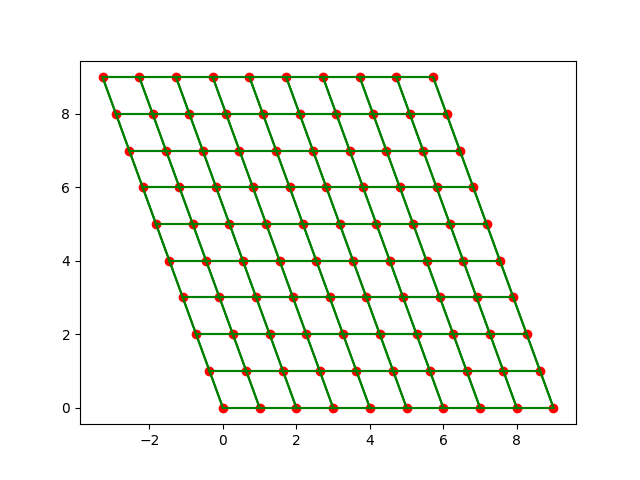

In [23]:
nodes = get_nodes(*get_lattice_vectors(1, 90), size=[10,10])
#nodes *= np.array([2,1])
nodes = nodes + np.stack((nodes[:,1]/np.tan(np.radians(110)), np.zeros_like(nodes[:,1])), axis=1)
cons = get_connections(nodes, [10,10])
plot_graph(nodes, cons)

In [48]:
class Test:
    def __init__(self):
        self.size = [10,10]
        self._set_standard_graphs()
        
    def _set_standard_graphs(self):
        '''
        This helper method is used to set standard square and hexagonal lattices with connections. 
        As this is inefficent, these are set once and later only modified by array operations.
        '''
        # Square
        nodes = []
        for i in range(self.size[0]):
            for j in range(self.size[1]):
                node = j*np.array([1,0]) + i*np.array([0,1])
                nodes.append([node[0], node[1]])
        self.square_nodes = np.array(nodes)
        # Hexagonal
        e1 = np.array([1,0])
        e2 = np.array([1*0.5,1*(np.sqrt(3)/2)]) # cos(120°) and sin(120°) resp.
        nodes = []
        for i in range(self.size[0]):
            for j in range(self.size[1]):
                node = j*e1 + i*e2
                nodes.append([node[0], node[1]])
        self.hex_nodes = np.array(nodes)
        
        # Connections for square lattice
        max_index = len(self.square_nodes)
        edges = []
        for i in range(max_index):
            if i+1 < max_index and (i+1)%self.size[1] != 0:
                edges.extend([[i, i+1], [i+1, i]])
            if i+self.size[1] < max_index:
                edges.extend([[i, i+self.size[1]], [i+self.size[1], i]])
        self.square_cons = np.array(edges).T
        # Connections for hexagonal lattice
        max_index = len(self.hex_nodes)
        edges = []
        for i in range(max_index):
            if (i+1)%self.size[1] != 0:
                # There is a node to the right
                edges.extend([[i, i+1], [i+1, i]])
            if i+self.size[1] < max_index:
                # There is a node above
                edges.extend([[i, i+self.size[1]], [i+self.size[1], i]])
            if i%self.size[1] != 0 and i+self.size[1]-1 < max_index:
                # There is a node to the upper left
                edges.extend([[i, i+self.size[1]-1], [i+self.size[1]-1, i]])
        self.hex_cons = np.array(edges).T      
        
def _get_square_graph(self):
    '''
    Method that returns the position and connections of a square lattice. Applies randomly different sorts of noise to the "perfect" lattice.
    '''
    # Apply a random scaling of the lattice (but ensure squareness)
    scale = rng.uniform(0.5, 2)
    nodes = self.square_nodes*scale
    # Apply gaussian noise with random standard deviation
    noise_level = rng.uniform(0, 0.2)
    nodes += rng.normal(0, noise_level, nodes.shape)
    # Apply a random systematic skew, maybe later
    # skew_angle = rng.uniform(-10, 10)
    # nodes += np.stack((nodes[:,1]/np.tan(np.radians(90 + skew_angle)), np.zeros_like(nodes[:,1])), axis=1)
    
    # For now, no alterations to connections
    connections = self.square_cons
    return nodes, connections
    
def _get_rect_graph(self):
    # Apply a random scaling of the lattice that makes it rectangular
    scale = rng.uniform(0.5, 2, 2)
    nodes = self.square_nodes*scale
    # Apply gaussian noise with random standard deviation
    noise_level = rng.uniform(0, 0.2)
    nodes += rng.normal(0, noise_level, nodes.shape)
    # Apply a random systematic skew, maybe later
    # skew_angle = rng.uniform(-10, 10)
    # nodes += np.stack((nodes[:,1]/np.tan(np.radians(90 + skew_angle)), np.zeros_like(nodes[:,1])), axis=1)
    
    # For now, no alterations to connections
    connections = self.square_cons
    return nodes, connections

def _get_hex_graph(self):
    # Apply a random scaling of the lattice
    scale = rng.uniform(0.5, 2)
    nodes = self.hex_nodes*scale
    # Apply gaussian noise with random standard deviation
    noise_level = rng.uniform(0, 0.2)
    nodes += rng.normal(0, noise_level, nodes.shape)
    # Apply a random systematic skew, maybe later
    # skew_angle = rng.uniform(-10, 10)
    # nodes += np.stack((nodes[:,1]/np.tan(np.radians(90 + skew_angle)), np.zeros_like(nodes[:,1])), axis=1)
    
    # For now, no alterations to connections
    connections = self.hex_cons
    return nodes, connections


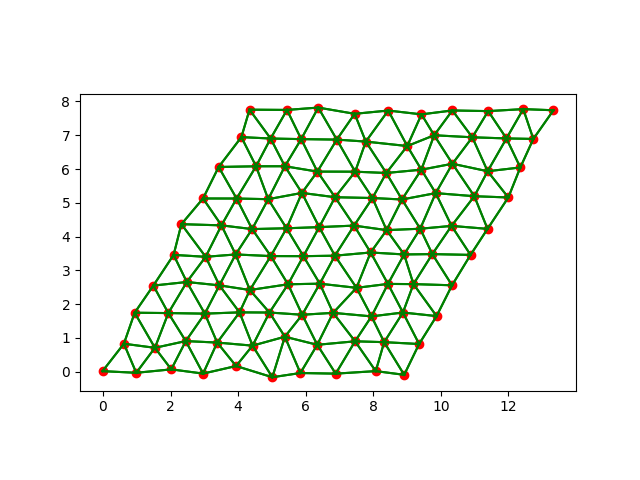

In [50]:
graph = Test()
plot_graph(*_get_hex_graph(graph))